# MNIST Digit Classification - Convolutional Neural Network

In [1]:
from __future__ import division, print_function
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.models import Sequential, load_model
from keras.layers.core import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.utils import np_utils
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib inline

Using TensorFlow backend.


In [2]:
DATA_DIR = "../../data"
TRAIN_FILE = os.path.join(DATA_DIR, "mnist_train.csv")
TEST_FILE = os.path.join(DATA_DIR, "mnist_test.csv")

BEST_MODEL = os.path.join(DATA_DIR, "keras-mnist-cnn-best.h5")
FINAL_MODEL = os.path.join(DATA_DIR, "keras-mnist-cnn-final.h5")
TENSORBOARD_LOGS_DIR = os.path.join(DATA_DIR, "keras-mnist-cnn-tensorboard")

BATCH_SIZE = 128
NUM_CLASSES = 10
NUM_EPOCHS = 5

## Prepare Data

Input shape for X will be (28, 28, 1) images in this case.

In [3]:
def parse_file(filename):
    xdata, ydata = [], []
    fin = open(filename, "rb")
    i = 0
    for line in fin:
        if i % 10000 == 0:
            print("{:s}: {:d} lines read".format(
                    os.path.basename(filename), i))
        cols = line.strip().split(",")
        ydata.append(int(cols[0]))
        x1d = np.array([float(x) / 255.0 for x in cols[1:]])
        x3d = np.reshape(x1d, (28, 28, 1))
        xdata.append(x3d)
        i += 1
    print("{:s}: {:d} lines read".format(os.path.basename(filename), i))
    fin.close()
    Y = np_utils.to_categorical(np.array(ydata), num_classes=NUM_CLASSES)
    X = np.array(xdata)
    return X, Y

Xtrain, Ytrain = parse_file(TRAIN_FILE)
Xtest, Ytest = parse_file(TEST_FILE)
print(Xtrain.shape, Ytrain.shape, Xtest.shape, Ytest.shape)

mnist_train.csv: 0 lines read
mnist_train.csv: 10000 lines read
mnist_train.csv: 20000 lines read
mnist_train.csv: 30000 lines read
mnist_train.csv: 40000 lines read
mnist_train.csv: 50000 lines read
mnist_train.csv: 60000 lines read
mnist_test.csv: 0 lines read
mnist_test.csv: 10000 lines read
(60000, 28, 28, 1) (60000, 10) (10000, 28, 28, 1) (10000, 10)


## Define Network

Model defined is identical to that in Keras example [mnist_cnn.py](https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py).

In [4]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation="relu", input_shape=(28, 28, 1)))
model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(NUM_CLASSES, activation="softmax"))

In [5]:
model.compile(optimizer="adam", loss="categorical_crossentropy",
              metrics=["accuracy"])

In [6]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

## Train Network

The Tensorboard callback, if enabled will write out the training logs to the directory given by TENSORBOARD_LOGS_DIR, and you can now start the tensorboard server using the following command:

    tensorboard --logdir=/path/to/TENSORBOARD_LOGS_DIR
    
The tensorboard application can be accessed from the browser at http://localhost:6060

In [7]:
checkpoint = ModelCheckpoint(filepath=BEST_MODEL, save_best_only=True)
tensorboard = TensorBoard(log_dir=TENSORBOARD_LOGS_DIR, 
                          histogram_freq=1, 
                          batch_size=BATCH_SIZE, 
                          write_graph=True, 
                          write_grads=True, 
                          write_images=True, 
                          embeddings_freq=0, 
                          embeddings_layer_names=None, 
                          embeddings_metadata=None)
history = model.fit(Xtrain, Ytrain, batch_size=BATCH_SIZE, 
                    epochs=NUM_EPOCHS,
                    validation_split=0.1,
                    callbacks=[checkpoint, tensorboard])

Train on 54000 samples, validate on 6000 samples
Epoch 1/5
54000/54000 [==============================] - 105s - loss: 0.2764 - acc: 0.9146 - val_loss: 0.0507 - val_acc: 0.9853
Epoch 2/5
54000/54000 [==============================] - 122s - loss: 0.0943 - acc: 0.9719 - val_loss: 0.0528 - val_acc: 0.9858
Epoch 3/5
54000/54000 [==============================] - 117s - loss: 0.0705 - acc: 0.9794 - val_loss: 0.0368 - val_acc: 0.9888
Epoch 4/5
54000/54000 [==============================] - 121s - loss: 0.0587 - acc: 0.9816 - val_loss: 0.0349 - val_acc: 0.9902
Epoch 5/5
54000/54000 [==============================] - 120s - loss: 0.0475 - acc: 0.9855 - val_loss: 0.0317 - val_acc: 0.9913


In [8]:
model.save(FINAL_MODEL, overwrite=True)

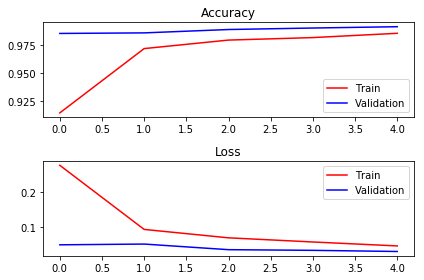

In [9]:
plt.subplot(211)
plt.title("Accuracy")
plt.plot(history.history["acc"], color="r", label="Train")
plt.plot(history.history["val_acc"], color="b", label="Validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss")
plt.plot(history.history["loss"], color="r", label="Train")
plt.plot(history.history["val_loss"], color="b", label="Validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

## Evaluate Network

In [10]:
def evaluate_model(model, model_name):
    print("==== eval {:s} model on test set ====".format(model_name))
    Ytest_ = model.predict(Xtest)
    ytest = np.argmax(Ytest, axis=1)
    ytest_ = np.argmax(Ytest_, axis=1)
    acc = accuracy_score(ytest, ytest_)
    cm = confusion_matrix(ytest, ytest_)
    print("Accuracy: {:.4f}".format(acc))
    print("Confusion Matrix")
    print(cm)

evaluate_model(model, "best")

model = load_model(BEST_MODEL)
evaluate_model(model, "final")

==== eval best model on test set ====
Accuracy: 0.9903
Confusion Matrix
[[ 977    0    0    1    0    1    0    0    1    0]
 [   0 1130    1    3    0    0    1    0    0    0]
 [   1    1 1022    1    0    0    0    6    1    0]
 [   0    0    2 1003    0    2    0    1    1    1]
 [   0    0    1    0  970    0    5    0    1    5]
 [   3    0    0    6    0  881    2    0    0    0]
 [   6    2    0    0    1    1  948    0    0    0]
 [   0    3    5    2    0    0    0 1016    1    1]
 [   4    1    1    1    1    0    0    3  960    3]
 [   1    1    0    1    2    4    0    2    2  996]]
==== eval final model on test set ====
Accuracy: 0.9903
Confusion Matrix
[[ 977    0    0    1    0    1    0    0    1    0]
 [   0 1130    1    3    0    0    1    0    0    0]
 [   1    1 1022    1    0    0    0    6    1    0]
 [   0    0    2 1003    0    2    0    1    1    1]
 [   0    0    1    0  970    0    5    0    1    5]
 [   3    0    0    6    0  881    2    0    0    0]
 [   6